this notebook demostrate the DR methods for time-series
(some normal methods also in consideration)
`GPFA`
`demixed-PCA`
`LDS`
`NLDS`
`HMM`
`PCA`/ `t-SNE` / `NMF` / `ISOMAP` / `UMAP` / `LLE` / `LE`
`NMF` / `ICA` / `LDA` / `Auto-Encoder`

In [2]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process

def integrated_oscillator(dt, num_steps, x0=0, y0=1, 
                          angular_frequency=2*np.pi*1e-3):
    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))

def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    def _lorenz_ode(point_of_interest, timepoint, 
                    sigma, rho, beta, tau):
        x, y, z = point_of_interest
        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot
    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T

def random_projection(data, embedding_dimension, loc=0, scale=None):
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)

def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)
    return spiketrains

In [3]:
# 1. Generate synthetic spike train data
### a. params set
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)
max_rate = 70 * pq.Hz
np.random.seed(42)
num_trials = 20
num_spiketrains = 50
num_steps

2000

In [5]:
### b. low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')
times_oscillator.shape, oscillator_trajectory_2dim.shape

((2000,), (2, 2000))

In [7]:
### c. random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)
### d. convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)
### generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

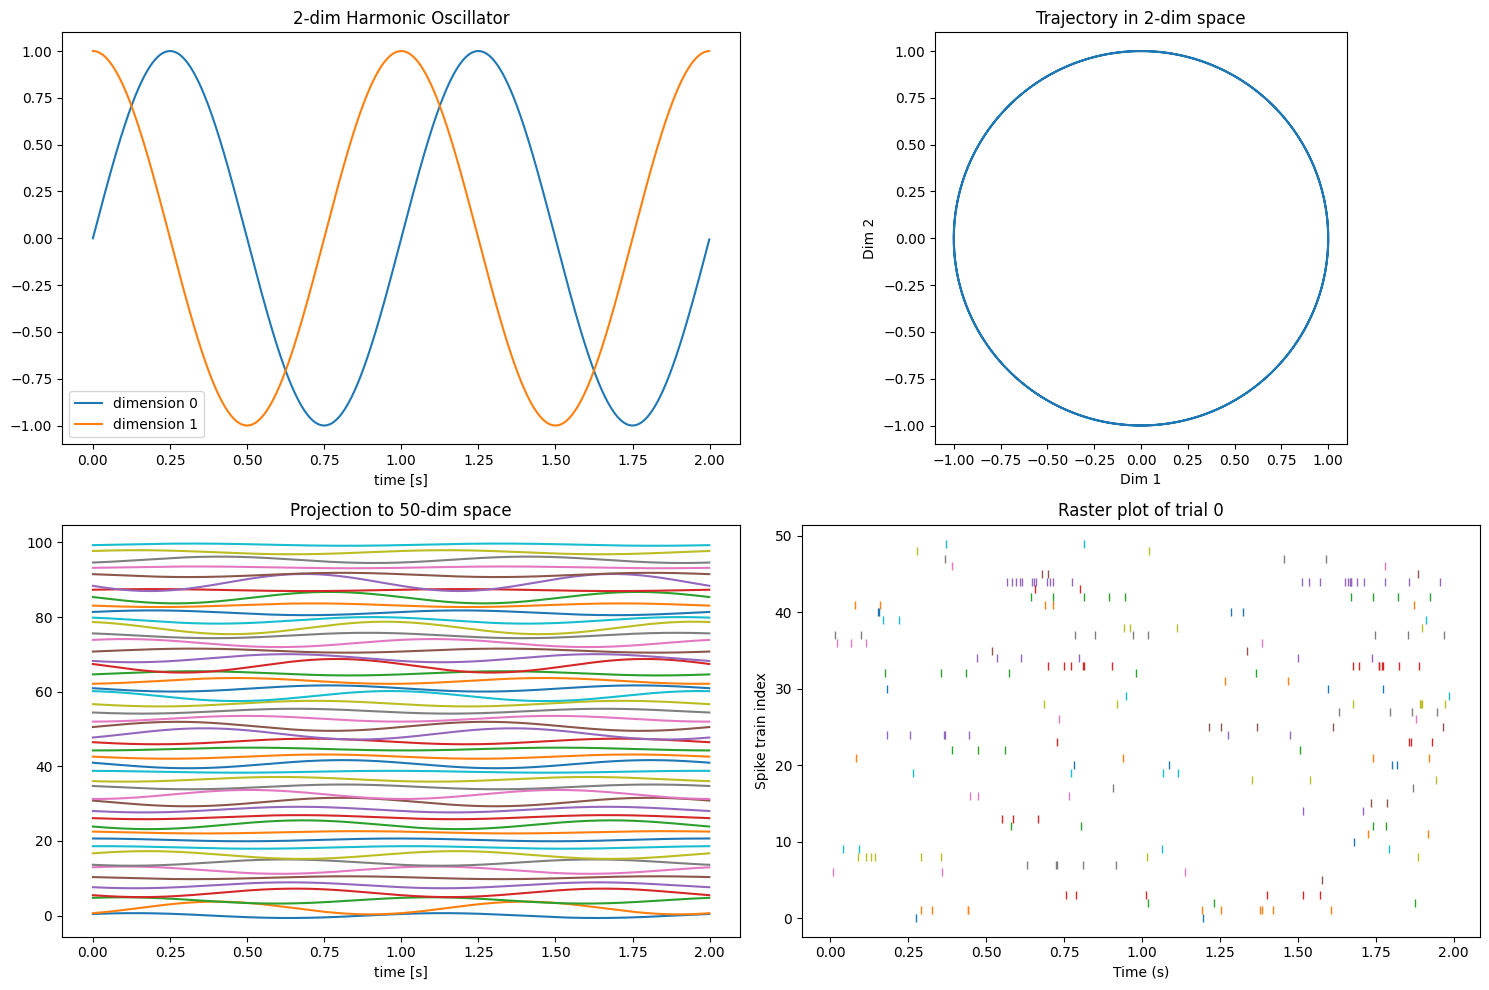

In [13]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()


In [19]:
from elephant.gpfa import GPFA
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
gpfa_2dim.fit(spiketrains_oscillator)
trajectories = gpfa_2dim.transform(spiketrains_oscillator)
trajectories.shape

Initializing parameters using factor analysis...

Fitting GPFA model...


(20,)

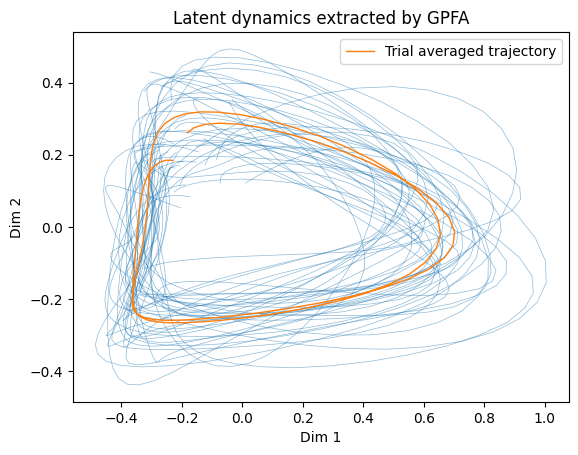

In [21]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
color_0 = 'C0'
color_1 = 'C1'
alpha_single_trial = 0.5
linewidth_trial_average = 2

fig, ax = plt.subplots()
ax.set_title('Latent dynamics extracted by GPFA')
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
for tr in trajectories:
    ax.plot(tr[0], tr[1], '-', lw=0.5, c=color_0, alpha=0.5)
aver_tr = np.mean(trajectories, axis=0)
ax.plot(aver_tr[0], aver_tr[1], '-', lw=1, c=color_1, label='Trial averaged trajectory')
ax.legend()

plt.show()